### Some markdown is never a bad idea


In [2]:
import pandas as pd
import numpy as np
import time
# visualization modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning models
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pickle

In [3]:
# Reading the file from disk
matches = pd.read_csv('data/seasons_merged.csv')
letter_to_result = {'H': 1, 'D': 0, 'A': -1}

matches

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HY,AY,HR,AR,B365H,B365D,B365A,BbAvH,BbAvD,BbAvA
0,0,2009-08-15,Aston Villa,Wigan,0,2,-1,0,1,A,...,2,2,0,0,1.67,3.60,5.50,1.66,3.51,5.33
1,1,2009-08-15,Blackburn,Man City,0,2,-1,0,1,A,...,2,1,0,0,3.60,3.25,2.10,3.37,3.24,2.12
2,2,2009-08-15,Bolton,Sunderland,0,1,-1,0,1,A,...,2,1,0,0,2.25,3.25,3.25,2.24,3.20,3.15
3,3,2009-08-15,Chelsea,Hull,2,1,1,1,1,D,...,1,2,0,0,1.17,6.50,21.00,1.17,6.26,16.39
4,4,2009-08-15,Everton,Arsenal,1,6,-1,0,3,A,...,0,0,0,0,3.20,3.25,2.30,3.07,3.21,2.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,3795,2019-12-05,Liverpool,Wolves,2,0,1,1,0,H,...,0,2,0,0,1.30,6.00,11.00,1.30,5.62,10.17
3796,3796,2019-12-05,Man United,Cardiff,0,2,-1,0,1,A,...,3,3,0,0,1.28,6.50,11.00,1.28,6.18,10.10
3797,3797,2019-12-05,Southampton,Huddersfield,1,1,0,1,0,H,...,0,1,0,0,1.44,4.75,8.50,1.42,4.81,7.64
3798,3798,2019-12-05,Tottenham,Everton,2,2,0,1,0,H,...,0,2,0,0,2.20,3.50,3.50,2.09,3.51,3.58


In [4]:
def get_n_last_matches(matches, date, team, n = 10):
    '''
    Get the last n matches of a given team.
    '''
    # All matches with a given team
    team_matches = matches[(matches['HomeTeam'] == team) | (matches['AwayTeam'] == team)]
    
    #Filter n last matches from team matches
    n_last_matches = (team_matches[team_matches.Date < date]
                      .sort_values(by = 'Date', ascending = False)
                      .iloc[0:n,:])
    
    return n_last_matches


def get_n_last_matches_against_each_other(matches, date, home_team, away_team, n = 5):
    ''' 
    Get the last n matches of two given teams. If possible, else
    get all matches available
    '''
    
    home_matches = matches[(matches['HomeTeam'] == home_team) & (matches['AwayTeam'] == away_team)]    
    away_matches = matches[(matches['HomeTeam'] == away_team) & (matches['AwayTeam'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    
    # Get last n matches, if possible:
    try:    
        last_matches = (total_matches[total_matches.Date < date]
                        .sort_values(by = 'Date', ascending = False)
                        .iloc[0:n,:])
    except:  # If there are less than n matches
        last_matches = (total_matches[total_matches.Date < date]
                        .sort_values(by = 'Date', ascending = False)
                        .iloc[0:total_matches.shape[0],:])

    return last_matches


def get_goals(matches, team):
    '''
    Get total number of goals,a specfic team has scored 
    from a dataframe of specific matches
    '''
    home_goals = matches.FTHG[matches.HomeTeam == team].sum()
    away_goals = matches.FTAG[matches.AwayTeam == team].sum()

    return home_goals + away_goals

def get_concealed_goals(matches, team):
    '''
    Get all the goals, concealed of a specfic team from a dataframe of specific matches
    '''
    home_goals = matches.FTAG[matches.HomeTeam == team].sum()
    away_goals = matches.FTHG[matches.AwayTeam == team].sum()

    return home_goals + away_goals

def get_wins(matches, team):
    '''
    Get the number of wins of a specfic team from a dataframe of specific matches.
    '''
    home_wins = matches[(matches.FTR == 1) & (matches.HomeTeam == team)].shape[0]
    away_wins = matches[(matches.FTR == -1) & (matches.AwayTeam == team)].shape[0]

    return home_wins + away_wins


def coefficients_to_probability(matches):
    '''
    Converts betting platform coefficient(1 < x) with % of income
    into a probability coefficient(0 < x < 1)
    '''
    # How many profit betting companies make on bets
    matches['profit_B365'] = sum((1/matches['B365H'], 1/matches['B365D'], 1/matches['B365A']))
    matches['profit_BbAv'] = sum((1/matches['BbAvA'], 1/matches['BbAvD'], 1/matches['BbAvH']))

    # Converting all betting coefficients into probabilities of homw/draw/away:
    for betting_column in ['B365H', 'B365D', 'B365A', 'BbAvH', 'BbAvD', 'BbAvA']:
        matches[betting_column] = 1 / (matches[betting_column] * matches['profit_' + betting_column[:-1]])

    return matches
# get_n_last_matches_against_each_other(matches, '2020-12-15', 'Liverpool', 'Tottenham', 10)


In [5]:
# Create features, based on which, the model would train and predict results

def get_features_for_match(match, matches, n1=10, n2=3):
    '''
    Creates a special set of features for each match, if possible(10 last matches
    and 3 last matches against each other)
    '''
    match_date = match.Date
    home_team = match.HomeTeam
    away_team = match.AwayTeam
    # Get n1 last matches of 2 teams
    home_last = get_n_last_matches(matches, match_date, home_team, n=n1)
    away_last = get_n_last_matches(matches, match_date, away_team, n=n1)
    # Get last n2 matches against each other
    home_last_against = get_n_last_matches_against_each_other(matches, match_date, home_team, away_team, n=n2)
    away_last_against = get_n_last_matches_against_each_other(matches, match_date, away_team, home_team, n=n2)
    # Goals stuff
    home_goals = get_goals(home_last, home_team)
    away_goals = get_goals(away_last, away_team)
    home_goals_conceided = get_concealed_goals(home_last, home_team)
    away_goals_conceided = get_concealed_goals(away_last, away_team)

    res = pd.DataFrame()
    res.loc[0, 'H_goal_diff'] = home_goals - home_goals_conceided
    res.loc[0, 'A_goal_diff'] = away_goals - away_goals_conceided
    res.loc[0, 'H_win'] = get_wins(home_last, home_team) 
    res.loc[0, 'A_win'] = get_wins(away_last, away_team)
    res.loc[0, 'H_win_against'] = get_wins(home_last_against, home_team)
    res.loc[0, 'A_win_against'] = get_wins(away_last_against, away_team)
    # TODO ПОПРООБУВАТИ ЩЕ ЯКІСЬ КРИТЕРІЇ ПОТЕСТУВАТИ
#     print(result.loc[0])
    return res.loc[0]


def create_features(matches):
    '''
    Iterate throu all matches, create features for every single of them
    if possible and aggregate them together
    '''
    print('Generating features... Please wait for one or two minutes')
    # Creates dataframe with features for all matches
    matches_features = matches.apply(lambda x: get_features_for_match(x, matches, n1=20, n2=3), axis=1)
    return matches_features

def explore_features(features, inputs, path):
    '''
    Explore data by plotting KDE graphs.
    '''
    fig = plt.figure(1)
    fig.subplots_adjust(bottom= -1, left=0.025, top = 2, right=0.975)
    #Loop through features    
    i = 1
    for col in features.columns:
        sns.set_style("whitegrid")
        sns.set_context("paper", font_scale = 0.5, rc={"lines.linewidth": 1})
        plt.subplot(5,5,0 + i)
        j = i - 1
        #Plot KDE for all labels
        try:
            sns.distplot(inputs[inputs['label'] == 'H'].iloc[:,j], hist = False, label = 'Home')
            sns.distplot(inputs[inputs['label'] == 'D'].iloc[:,j], hist = False, label = 'Draw')
            sns.distplot(inputs[inputs['label'] == 'A'].iloc[:,j], hist = False, label = 'Away')
            plt.legend();
        except ValueError as e:
            print(e)
        i = i + 1
    #Define plot format    
    DefaultSize = fig.get_size_inches()
    fig.set_size_inches((DefaultSize[0]*1.2, DefaultSize[1]*1.2))
    plt.show()
    #Compute and print label weights
    labels = inputs.loc[:,'label']
    class_weights = labels.value_counts() / len(labels)
    print(class_weights)
    #Store description of all features
    feature_details = features.describe().transpose()
    #Return feature details
    return feature_details

In [6]:
# Getting features ready

# If you want to create features instead of reading them from file, uncomment:

# time_start = time.time()
# features = create_features(matches)
# print('Generated features in', time.time() - time_start, 'sec.')
# features.iloc[100:].to_csv('data/features.csv')

# Reading files from the file
features = pd.read_csv('data/features.csv')
# features = features.drop('Unnamed: 0', axis=1)




### Printing statistics to see the correlations:
```python3
statistic = explore_features(features, inputs, '/soccer/')
statistic
```

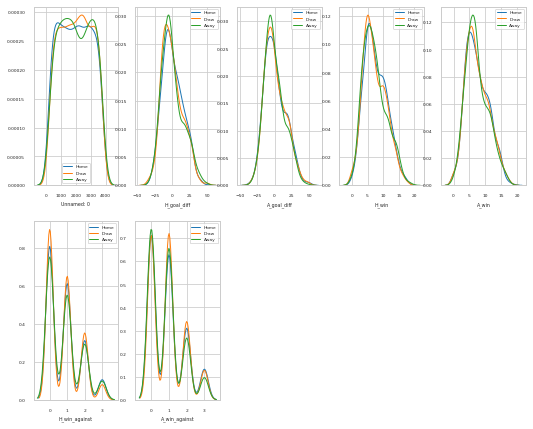

D    0.413889
H    0.346944
A    0.239167
Name: label, dtype: float64


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,3700.0,1949.500000,1068.242326,100.0,1024.75,1949.5,2874.25,3799.0
H_goal_diff,3700.0,0.236757,14.861263,-37.0,-11.00,-2.0,10.00,53.0
A_goal_diff,3700.0,0.559459,14.841652,-37.0,-10.00,-2.0,10.00,52.0
H_win,3700.0,7.309730,3.570593,0.0,5.00,7.0,10.00,19.0
A_win,3700.0,7.385405,3.561851,0.0,5.00,7.0,10.00,19.0
H_win_against,3700.0,0.808108,0.888142,0.0,0.00,1.0,1.00,3.0
A_win_against,3700.0,0.886486,0.906604,0.0,0.00,1.0,1.00,3.0


In [7]:
# Determining labels, which we want to train on, and then predict them

labels = matches.loc[:, 'HTR']
labels.name = 'label'
labels = labels.iloc[100:]
# coefficients = coefficients_to_probability(matches)[['BbAvH','BbAvD','BbAvA']]
# features = pd.merge(features, coefficients, left_index=True, right_index=True)
# statistic = explore_features(features, features.deo, '/soccer/')
# statistic

inputs = pd.merge(features, labels, left_index=True, right_index=True)
statistic = explore_features(features, inputs, '/soccer/')
statistic

# Machine learning part 


In [8]:
# Splitting the data into training and testing parts
# Standardising the data.
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.

X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size = 400,
                                                    random_state = 2,
                                                    stratify = labels)

# Classifiers
# Defyning classifiers:

clf_A = LogisticRegression(random_state = 42, max_iter=1200000)
clf_B = SVC(random_state = 912, kernel='rbf', max_iter=1200000)
clf_C = xgb.XGBClassifier(seed = 82)

# After maxyzizing, the following parameters proved to behave the best:
clf_boosted = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=40, nthread=-1,
       objective='binary:logistic', reg_alpha=1e-05, reg_lambda=1,
       scale_pos_weight=1, seed=2, silent=True, subsample=0.8)

In [9]:
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' 
    Fits and overall trains a classifier to the training data. 
    '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    
    # Print the results
    print(f"Trained model in {end - start} seconds")

    
def predict_labels(clf, features, target):
    '''
    Makes predictions using a fit classifier based on F1 score. 
    '''
    
    # Start the clock, make predictions, then stop the clock
    start = time.time()
    y_pred = clf.predict(features)
    
    end = time.time()
    # Print and return results
    print(f"Predicted in {end - start} seconds")
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predi


    
def predict_labels(clf, features, target):
    '''
    Makes predictions using a fit classifier based on F1 score. 
    '''
    
    # Start the clock, make predictions, then stop the clock
    start = time.time()
    y_pred = clf.predict(features)
    
    end = time.time()
    # Print and return results
    print(f"Predicted in {end - start} seconds")
#     print(f1_score(target, y_pred, pos_label=1))
    return f1_score(target, y_pred, pos_label=1), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    '''
    Train and predict using a given classifer
    '''
    
    # Indicate the classifier and the training set size
    print(f"Training a {clf.__class__.__name__} using a training set size of {len(X_train)}")
    
 # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print(f"Accyracy on training set: {acc}.")
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print(f"Accyracy on test set: {acc}.")




In [10]:
y_train = y_train.apply(lambda x: 1 if x == 'H' else 0)
y_test = y_test.apply(lambda x: 1 if x == 'H' else 0)

y_test[:5]

2447    0
2316    0
3250    0
3673    0
2241    1
Name: label, dtype: int64

In [11]:




# This are developer tools, uncomment them and play around if you want to
train_predict(clf_A, X_train, y_train, X_test, y_test)
print()
train_predict(clf_B, X_train, y_train, X_test, y_test)
print()
train_predict(clf_C, X_train, y_train, X_test, y_test)
print()
clf_A.fit(X_train, y_train)
y_pred = clf_A.predict(X_test)


y_pred  
#     end = time.time()
#     # Print and return results
#     print(f"Predicted in {end - start} seconds")
# #     print(f1_score(target, y_pred, pos_label=1))
#     print(y_pred == target)



# I will save the model after training:
# with open('models/finalized_model.sav', 'w') as f:
#     pass

# Main training of the model
# start = time.time()
# print('training home model')
# clf_boosted.fit(X_train, y_train)
# print(f"took {time.time() - start}")
# start = time.time()



# # save the models to disk
# pickle.dump(clf_boosted, open('models/finalized_model.sav', 'wb'))
# y_train

Training a LogisticRegression using a training set size of 3300
Trained model in 0.03265571594238281 seconds
Predicted in 0.0017886161804199219 seconds
Accyracy on training set: 0.6721212121212121.
Predicted in 0.0013942718505859375 seconds
Accyracy on test set: 0.6575.

Training a SVC using a training set size of 3300
Trained model in 0.18880367279052734 seconds
Predicted in 0.11607813835144043 seconds
Accyracy on training set: 0.6533333333333333.
Predicted in 0.015352725982666016 seconds
Accyracy on test set: 0.655.

Training a XGBClassifier using a training set size of 3300
Trained model in 0.14288926124572754 seconds
Predicted in 0.00505375862121582 seconds
Accyracy on training set: 0.9409090909090909.
Predicted in 0.0010502338409423828 seconds
Accyracy on test set: 0.6.



array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,

### Методом спроб і помилок я визначив, що під цю проблему найкраще підходить XGBClassifier. Зараз я в лоб переберу вхідні параметри так, щоб максимізувати точність.


In [13]:




from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import sklearn


# Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

best_clf = xgb.XGBClassifier(seed=2)

f1_scorer = make_scorer(f1_score,pos_label=1)

grid_obj = GridSearchCV(best_clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_obj.best_estimator_

# the final score for training and testing after parameter tuning
print(f"Boosted XGBClassifier:")
f1, acc = predict_labels(best_clf, X_train, y_train)
print(f"Accuracy score for test set: {acc}")



Boosted XGBClassifier:
Predicted in 0.001989603042602539 seconds
Accuracy score for test set: 0.6875757575757576


### Saving a model we got to disk

In [16]:
# save the models to disk
pickle.dump(best_clf, open('models/finalized_model.sav', 'wb'))


### Testing output.
Splitting again, but this time with 100% of training data

In [29]:

X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size = 10,
                                                    random_state = 2,
                                                    stratify = labels)


# load the model from disk
clf_boosted = pickle.load(open('models/finalized_model.sav', 'rb'))
clf_boosted.fit(X_train, y_train)
# make a prediction

to_predict = X_test.iloc[-5:-4]

print(to_predict)
away_win, draw, home_win = clf_boosted.predict_proba(to_predict)[0]

print('Away win: ', away_win)
print('Draw: ', draw)
print('Home win: ', home_win)


[08:29:39] WARNING: /workspace/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


      H_goal_diff  A_goal_diff  H_win  A_win  H_win_against  A_win_against
3596         38.0          5.0   16.0    7.0            2.0            0.0
Away win:  0.09261296
Draw:  0.34364447
Home win:  0.5637426
